# Consistency check 3

In this file I check the consistency of the thermalization. I evolve in an exact manner the thermal state and do the same with the TEDB algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [2]:
### PROBLEM PARAMETERS
L = 7         # chain length
omega = 1     # Rabi frequency
V = 0.1       # B-S interaction strength
V_ = 1        # bath interaction strength
beta = 0.1    # inverse temperature for the bath

T = 10        # total time of the simulation
dt = 0.1      # time step for coherece vector time evolution

cutoff = 1e-8 # cutoff for TEBD algorithm

### USEFULL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('Y')
Z = qu.pauli('Z')

In [3]:
def isherm(M):
    return (M.H - M == 0).all()

### Exact simulation

In [4]:
### BUILDING THE HAMILTONIAN

# fisrt I build the operators
nn_op = (I + Z)/2 & (I + Z)/2

print(f'Building Hamiltonian for L={L}')
# the hamiltonian
H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

# diagonalization
e, U = la.eig(H, isherm=True)

print('done :)')

Building Hamiltonian for L=7
done :)


In [5]:
### BUILDING THE OBSERVABLES

observables_ex = {}
results_ex = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results_ex[key] = []
    observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

# dropping the identity
observables_ex.pop('I1I2')
results_ex.pop('I1I2')


### INITIAL CONDITIONS
print('Initial state: random subsystem and thermal bath\n')
# creation of the Hamiltonian of the Bath
#dims_th = [2]*(L-2)
#H_Rabi = sum(qu.ikron(X, dims_th, i) for i in range(L-2))
#H_int_b = sum(qu.ikron(nn_op, dims_th, (i, i+1)) for i in range(L-2-1))

#H_bath = (omega/2)*H_Rabi + V_*H_int_b

# thermal state of the bath
#rho_bath = qu.gen.states.thermal_state(H_bath, beta)

# local state |up up>
#rho_loc = np.array([[1, 0, 0, 0],
#                    [0, 0, 0, 0],
#                    [0, 0, 0, 0],
#                    [0, 0, 0, 0]])

# density matrix of the full system
#rho = qu.kron(rho_loc, rho_bath)

#rho = la.expm(-beta*H)
#rho /= rho.trace()

rho = qu.gen.states.thermal_state(H, beta)

# apply a random operator to the first two spins
rand1 = qu.gen.rand.rand_uni(2)
rand2 = qu.gen.rand.rand_uni(2)
U_rand = qu.ikron(rand1 & rand2, dims, (0, 1))
#rho = U_rand @ rho @ U_rand.H

### THE SIMULATION

# smarter way to calculate the coherence vector:
rho_tilde = np.conj(U.T) @ rho @ U    

pauli_tilde = {}
t_ex = []
for key in observables_ex.keys():
    pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U
    
for i in range(0, int(T/dt)):
    ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
    rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)
        
    trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
    for key in results_ex.keys():
        results_ex[key].append(trace(key))
        
    t_ex.append( dt*i )
        
print("finished Time = %s" % T)
    
print('done')

Initial state: random subsystem and thermal bath

finished Time = 10
done


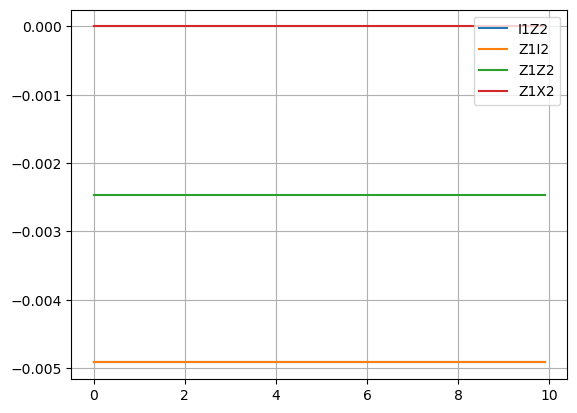

In [6]:
keys = results_ex.keys()
keys = ['I1Z2', 'Z1I2', 'Z1Z2', 'Z1X2']

for key in keys:
    plt.plot(t_ex, results_ex[key], label=key)
plt.legend()
plt.grid()

### TEBD

In [67]:
### BUILDING THE HAMILTONIAN for the thermalization

O_Rabi = (omega/2)*X & I
N_sys  = 0.5*V*(I + Z)/2 & I
N_bath = 0.5*V_*(I + Z)/2 & I

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
H2 = {None: N_bath&N_bath, (L-1, 0): N_sys&N_sys, (0, 1): N_sys&N_sys, (1, 2): N_sys&N_sys}

H_th = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### BUILDING THE SPIN CHAIN

print('Building the spin chain \n')
B = np.array([1, 0, 0, 1])/np.sqrt(2)
arrays = [B for i in range(L)]

psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

psi.show()

Building Hamiltonian for L=7 

Building the spin chain 

 1 1 1 1 1 1 1 1 
+─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │  


In [68]:
print(f'Check for the normalization: {psi.H @ psi}\n')

Check for the normalization: 0.9999999999999984



In [69]:
### IMAGINARY TIME EVOLUTION

print('Imaginary time evolution \n')

# create the object
tebd_th = my_TEBD(psi, H_th, imag=True)

# cutoff for truncating after each infinitesimal-time operator application
tebd_th.split_opts['cutoff'] = cutoff

tebd_th.update_to(beta/2, tol=1e-5)
psi_th = tebd_th.pt

psi_th.show() 

Imaginary time evolution 



t=0.05, max-bond=4: 100%|##################################################################################################################################################################################################| 100/100 [00:00<00:00, 4586.39%/s]

 2 2 2 3 3 3 3 2 
+─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │  


In [42]:
### IMAGINARY TIME EVOLUTION

print('Imaginary time evolution \n')

# create the object
tebd_th = qtn.TEBD(psi, H_th, imag=True)

# cutoff for truncating after each infinitesimal-time operator application
tebd_th.split_opts['cutoff'] = cutoff

tebd_th.update_to(beta, tol=1e-5)
psi_th_beta = tebd_th.pt

Imaginary time evolution 



t=0.1, max-bond=4: 100%|###################################################################################################################################################################################################| 100/100 [00:00<00:00, 3108.25%/s]


In [70]:
print(f'Check for the normalization beta/2: {psi_th.H @ psi_th}\n')
print(f'Check for the normalization beta: {psi.H @ psi_th_beta}\n')
#print(f'Check for the normalization beta: {psi.H @ psi_prova}\n')

Check for the normalization beta/2: 0.984036725212552

Check for the normalization beta: 0.5721398240588361



In [59]:
psi_th = psi_th.normalize()
print(f'Check for the normalization beta/2: {psi_th.H @ psi_th}\n')

AttributeError: 'numpy.complex128' object has no attribute 'H'

In [26]:
### BUILDING THE HAMILTONIAN for the thermalization

O_Rabi = (omega/2)*X & I
N_sys  = 0.5*V*(I + Z)/2 & I
N_bath = 0.5*V_*(I + Z)/2 & I

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
#H2 = {None: N_bath&N_bath, (L-1, 0): N_sys&N_sys, (0, 1): N_sys&N_sys, (1, 2): N_sys&N_sys}
H2 = {(i, i+1): N_bath for i in range(2, L-2)} 
H2[(L-1, 0)] = N_sys
H2[(0, 1)] = N_sys
H2[(1, 2)] = N_sys

#H_th = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

B = np.array([1, 0, 0, 1])/np.sqrt(2)
arrays = [B for i in range(L)]

psi_prova = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

### IMAGINARY TIME EVOLUTION
dt = 0.001

for i in range(int(beta/2/dt)):
    for term in H1:
        psi_prova.gate_(la.expm(-H1[term]*i*dt), term, contract='swap+split')
    for term in H2:
        psi_prova.gate_(la.expm(-H2[term]*i*dt)&la.expm(-H2[term]*i*dt), term, contract='swap+split')

Building Hamiltonian for L=7 



In [31]:
print(f'Check for the normalization beta/2: {psi_th.H @ psi_th}\n')
#print(f'Check for the normalization beta: {psi.H @ psi_th_beta}\n')
print(f'Check for the normalization beta: {psi_prova.H @ psi_prova}\n')

Check for the normalization beta/2: 0.499999999993222

Check for the normalization beta: (0.18324536822338441+0j)



In [28]:
print(f'Check for the normalization: {psi_th.H @ psi_th}\n')

Check for the normalization: 0.499999999993222



In [71]:
### INITIAL CONDITIONS

# I have to set the first 2 spins pointing up
#up_op = (qu.pauli('Z') + qu.pauli('I'))/2 + (qu.pauli('X') + 1j*qu.pauli('Y'))/2
#up_op = up_op & qu.pauli('I')

#qc = qtn.circuit.CircuitMPS(N=L, psi0=psi_th)
#qc.apply_gate_raw(up_op&up_op, (0,1))
#psi_init = qc.psi

# random initial conditions
Rand1 = rand1 & qu.pauli('I')
Rand2 = rand2 & qu.pauli('I')

#psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')
psi_init = psi_th.copy()
psi_init.show()

 2 2 2 3 3 3 3 2 
+─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │  


In [72]:
print(f'Check for the normalization: {psi_init.H @ psi_init}\n')

Check for the normalization: 0.984036725212552



In [73]:
### BUILDING THE HAMILTONIAN for the simulation

# first I build the operators tensor identity on ancilla states
# OCIO: I have to include the multiplicative parts from the beginning!
O_Rabi = (omega/2)*X & I
N_sys  = 0.5*V*(I + Z)/2 & I
N_bath = 0.5*V_*(I + Z)/2 & I

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
H2 = {None: N_bath&N_bath, (L-1, 0): N_sys&N_sys, (0, 1): N_sys&N_sys, (1, 2): N_sys&N_sys}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### THE SIMULATION

start = time.time()

# first I build the observables
observables_tebd = {}
results = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results[key] = []
    observables_tebd[key] = []

# dropping the identity
observables_tebd.pop('I1I2')
results.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi_init, H)

# cutoff for truncating after each infinitesimal-time operator application
tebd.split_opts['cutoff'] = cutoff

t = np.linspace(0, T, 100)
keys = results.keys()

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(t, tol=1e-3):
    for key in keys:
        ob1 = qu.pauli(key[0]) & qu.pauli('I')
        ob2 = qu.pauli(key[2]) & qu.pauli('I')
        results[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)
        
end = time.time()
print(f'Time:{int(end - start)}s')

Building Hamiltonian for L=7 



t=10, max-bond=19: 100%|####################################################################################################################################################################################################| 100/100 [00:04<00:00, 21.24it/s]

Time:4s


In [74]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')

Check for the normalization: (0.9840367891581216-1.0319853321301698e-17j)



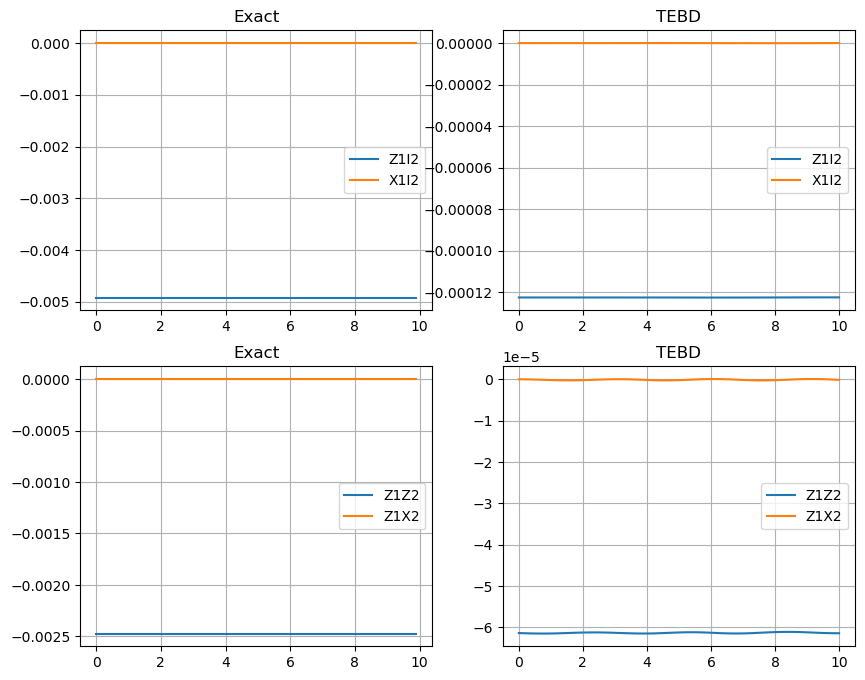

In [75]:
keys = observables_tebd.keys()
keys = ['Z1I2', 'X1I2']

fig, ax = plt.subplots(2, 2, figsize=(10,8))
for key in keys:
    ax[0][0].plot(t_ex, results_ex[key], label=key)
    ax[0][1].plot(t, results[key], label=key)    
ax[0][0].set_title('Exact')
ax[0][1].set_title('TEBD')

keys = ['Z1Z2', 'Z1X2']
for key in keys:
    ax[1][0].plot(t_ex, results_ex[key], label=key)
    ax[1][1].plot(t, results[key], label=key)
ax[1][0].set_title('Exact')
ax[1][1].set_title('TEBD')

for i in range(2):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()

#plt.savefig('./pictures/consistency_check_2.pdf')

In [ ]:
qu.core.com

In [66]:
import numpy as np

from quimb.utils import ensure_dict, continuous_progbar, deprecated
from quimb.utils import progbar as Progbar
from quimb.linalg.approx_spectral import norm_fro
from quimb.tensor.tensor_arbgeom_tebd import LocalHamGen

class my_TEBD:
    """Class implementing Time Evolving Block Decimation (TEBD) [1].

    [1] Guifré Vidal, Efficient Classical Simulation of Slightly Entangled
    Quantum Computations, PRL 91, 147902 (2003)

    Parameters
    ----------
    p0 : MatrixProductState
        Initial state.
    H : LocalHam1D or array_like
        Dense hamiltonian representing the two body interaction. Should have
        shape ``(d * d, d * d)``, where ``d`` is the physical dimension of
        ``p0``.
    dt : float, optional
        Default time step, cannot be set as well as ``tol``.
    tol : float, optional
        Default target error for each evolution, cannot be set as well as
        ``dt``, which will instead be calculated from the trotter orderm length
        of time, and hamiltonian norm.
    t0 : float, optional
        Initial time. Defaults to 0.0.
    split_opts : dict, optional
        Compression options applied for splitting after gate application, see
        :func:`~quimb.tensor.tensor_core.tensor_split`.
    imag : bool, optional
        Enable imaginary time evolution. Defaults to false.

    See Also
    --------
    quimb.Evolution
    """

    def __init__(self, p0, H, dt=None, tol=None, t0=0.0,
                 split_opts=None, progbar=True, imag=False):
        # prepare initial state
        self._pt = p0.copy()
        self._pt.canonize(0)
        self.L = self._pt.L

        # handle hamiltonian -> convert array to LocalHam1D
        if isinstance(H, np.ndarray):
            H = LocalHam1D(L=self.L, H2=H, cyclic=p0.cyclic)

        if not isinstance(H, LocalHam1D):
            raise TypeError("``H`` should be a ``LocalHam1D`` or 2-site "
                            "array, not a TensorNetwork of any form.")

        if p0.cyclic != H.cyclic:
            raise ValueError("Both ``p0`` and ``H`` should have matching OBC "
                             "or PBC.")

        self.H = H
        self.cyclic = H.cyclic
        self._ham_norm = H.mean_norm()
        self._err = 0.0

        # set time and tolerance defaults
        self.t0 = self.t = t0
        if dt and tol:
            raise ValueError("Can't set default for both ``dt`` and ``tol``.")
        self.dt = self._dt = dt
        self.tol = tol
        self.imag = imag

        # misc other options
        self.progbar = progbar
        self.split_opts = ensure_dict(split_opts)

    @property
    def pt(self):
        """The MPS state of the system at the current time.
        """
        return self._pt.copy()

    @property
    def err(self):
        return self._err

    def choose_time_step(self, tol, T, order):
        """Trotter error is ``~ (T / dt) * dt^(order + 1)``. Invert to
        find desired time step, and scale by norm of interaction term.
        """
        return (tol / (T * self._ham_norm)) ** (1 / order)


    def _get_gate_from_ham(self, dt_frac, sites):
        """Get the unitary (exponentiated) gate for fraction of timestep
        ``dt_frac`` and sites ``sites``, cached.
        """
        imag_factor = 1.0 if self.imag else 1.0j
        return self.H.get_gate_expm(sites, -imag_factor * self._dt * dt_frac)

    def sweep(self, direction, dt_frac, dt=None, queue=False):
        """Perform a single sweep of gates and compression. This shifts the
        orthonognality centre along with the gates as they are applied and
        split.

        Parameters
        ----------
        direction : {'right', 'left'}
            Which direction to sweep. Right is even bonds, left is odd.
        dt_frac : float
            What fraction of dt substep to take.
        dt : float, optional
            Overide the current ``dt`` with a custom value.
        """

        # if custom dt set, scale the dt fraction
        if dt is not None:
            dt_frac *= (dt / self._dt)

        # ------ automatically combine consecutive sweeps of same time ------ #

        if not hasattr(self, '_queued_sweep'):
            self._queued_sweep = None

        if queue:
            # check for queued sweep
            if self._queued_sweep:
                # if matches, combine and continue
                if direction == self._queued_sweep[0]:
                    self._queued_sweep[1] += dt_frac
                    return
                # else perform the old, queue the new
                else:
                    new_queued_sweep = [direction, dt_frac]
                    direction, dt_frac = self._queued_sweep
                    self._queued_sweep = new_queued_sweep

            # just queue the new sweep
            else:
                self._queued_sweep = [direction, dt_frac]
                return

        # check if need to drain the queue first
        elif self._queued_sweep:
            queued_direction, queued_dt_frac = self._queued_sweep
            self._queued_sweep = None
            self.sweep(queued_direction, queued_dt_frac, queue=False)

        # ------------------------------------------------------------------- #

        if direction == 'right':
            start_site_ind = 0
            final_site_ind = self.L - 1
            # Apply even gates:
            #
            #     o-<-<-<-<-<-<-<-<-<-   -<-<
            #     | | | | | | | | | |     | |       >~>~>~>~>~>~>~>~>~>~>~o
            #     UUU UUU UUU UUU UUU ... UUU  -->  | | | | | | | | | | | |
            #     | | | | | | | | | |     | |
            #      1   2   3   4   5  ==>
            #
            for i in range(start_site_ind, final_site_ind, 2):
                sites = (i, (i + 1) % self.L)
                U = self._get_gate_from_ham(dt_frac, sites)
                self._pt.left_canonize(start=max(0, i - 1), stop=i)
                self._pt.gate_split_(
                    U, where=sites, absorb='right', **self.split_opts)

            if (self.L % 2 == 1):
                self._pt.left_canonize_site(self.L - 2)
                if self.cyclic:
                    sites = (self.L - 1, 0)
                    U = self._get_gate_from_ham(dt_frac, sites)
                    self._pt.right_canonize_site(1)
                    self._pt.gate_split_(
                        U, where=sites, absorb='left', **self.split_opts)

        elif direction == 'left':

            if self.cyclic and (self.L % 2 == 0):
                sites = (self.L - 1, 0)
                U = self._get_gate_from_ham(dt_frac, sites)
                self._pt.right_canonize_site(1)
                self._pt.gate_split_(
                    U, where=sites, absorb='left', **self.split_opts)

            final_site_ind = 1
            # Apply odd gates:
            #
            #     >->->-   ->->->->->->->->-o
            #     | | |     | | | | | | | | |       o~<~<~<~<~<~<~<~<~<~<~<
            #     | UUU ... UUU UUU UUU UUU |  -->  | | | | | | | | | | | |
            #     | | |     | | | | | | | | |
            #           <==  4   3   2   1
            #
            for i in reversed(range(final_site_ind, self.L - 1, 2)):
                sites = (i, (i + 1) % self.L)
                U = self._get_gate_from_ham(dt_frac, sites)
                self._pt.right_canonize(
                    start=min(self.L - 1, i + 2), stop=i + 1)
                self._pt.gate_split_(
                    U, where=sites, absorb='left', **self.split_opts)

            # one extra canonicalization not included in last split
            self._pt.right_canonize_site(1)

        # Renormalise after imaginary time evolution
        #if self.imag:
        #    factor = self._pt[final_site_ind].norm()
        #    self._pt[final_site_ind] /= factor


    def _step_order2(self, tau=1, **sweep_opts):
        """Perform a single, second order step.
        """
        self.sweep('right', tau / 2, **sweep_opts)
        self.sweep('left', tau, **sweep_opts)
        self.sweep('right', tau / 2, **sweep_opts)

    def _step_order4(self, **sweep_opts):
        """Perform a single, fourth order step.
        """
        tau1 = tau2 = 1 / (4 * 4**(1 / 3))
        tau3 = 1 - 2 * tau1 - 2 * tau2
        self._step_order2(tau1, **sweep_opts)
        self._step_order2(tau2, **sweep_opts)
        self._step_order2(tau3, **sweep_opts)
        self._step_order2(tau2, **sweep_opts)
        self._step_order2(tau1, **sweep_opts)

    def step(self, order=2, dt=None, progbar=None, **sweep_opts):
        """Perform a single step of time ``self.dt``.
        """
        {2: self._step_order2,
         4: self._step_order4}[order](dt=dt, **sweep_opts)

        dt = self._dt if dt is None else dt
        self.t += dt
        self._err += self._ham_norm * dt ** (order + 1)

        if progbar is not None:
            progbar.cupdate(self.t)
            self._set_progbar_desc(progbar)


    def _compute_sweep_dt_tol(self, T, dt, tol, order):
        # Work out timestep, possibly from target tol, and checking defaults
        dt = self.dt if (dt is None) else dt
        tol = self.tol if (tol is None) else tol

        if not (dt or tol):
            raise ValueError("Must set one of ``dt`` and ``tol``.")
        if (dt and tol):
            raise ValueError("Can't set both ``dt`` and ``tol``.")

        if dt is None:
            self._dt = self.choose_time_step(tol, T - self.t, order)
        else:
            self._dt = dt

        return self._dt

    TARGET_TOL = 1e-13  # tolerance to have 'reached' target time

    def update_to(self, T, dt=None, tol=None, order=4, progbar=None):
        """Update the state to time ``T``.

        Parameters
        ----------
        T : float
            The time to evolve to.
        dt : float, optional
            Time step to use. Can't be set as well as ``tol``.
        tol : float, optional
            Tolerance for whole evolution. Can't be set as well as ``dt``.
        order : int, optional
            Trotter order to use.
        progbar : bool, optional
            Manually turn the progress bar off.
        """
        if T < self.t - self.TARGET_TOL:
            # can't go backwards yet
            raise NotImplementedError

        self._compute_sweep_dt_tol(T, dt, tol, order)

        # set up progress bar and start evolution
        progbar = self.progbar if (progbar is None) else progbar
        progbar = continuous_progbar(self.t, T) if progbar else None

        while self.t < T - self._dt:
            # get closer until we can reach in a single step
            self.step(order=order, progbar=progbar, dt=None, queue=True)

        # always perform final sweep with queue draining
        self.step(order=order, progbar=progbar, dt=T - self.t, queue=False)

        if progbar:
            progbar.close()


    def _set_progbar_desc(self, progbar):
        msg = f"t={self.t:.4g}, max-bond={self._pt.max_bond()}"
        progbar.set_description(msg)

    def at_times(self, ts, dt=None, tol=None, order=4, progbar=None):
        """Generate the time evolved state at each time in ``ts``.

        Parameters
        ----------
        ts : sequence of float
            The times to evolve to and yield the state at.
        dt : float, optional
            Time step to use. Can't be set as well as ``tol``.
        tol : float, optional
            Tolerance for whole evolution. Can't be set as well as ``dt``.
        order : int, optional
            Trotter order to use.
        progbar : bool, optional
            Manually turn the progress bar off.

        Yields
        ------
        pt : MatrixProductState
            The state at each of the times in ``ts``. This is a copy of
            internal state used, so inplace changes can be made to it.
        """
        # convert ts to list, to to calc range and use progress bar
        ts = sorted(ts)
        T = ts[-1]

        # need to use dt always so tol applies over whole T sweep
        dt = self._compute_sweep_dt_tol(T, dt, tol, order)

        # set up progress bar
        progbar = self.progbar if (progbar is None) else progbar
        if progbar:
            ts = Progbar(ts)

        for t in ts:
            self.update_to(t, dt=dt, tol=False, order=order, progbar=False)

            if progbar:
                self._set_progbar_desc(ts)

            yield self.pt

In [ ]:
#O_Rabi = np.zeros((4,4), dtype=complex)
#N_sys = np.zeros((4,4), dtype=complex)
#N_bath = np.zeros((4,4), dtype=complex)

#O_Rabi[:2, :2] = ((omega/2)*X)
#N_sys[:2, :2] = (V*(I + Z)/2)
#N_bath[:2, :2] = (V_*(I + Z)/2)

#O_Rabi = qu.quimbify(O_Rabi)
#N_bath = qu.quimbify(N_bath)
#N_sys = qu.quimbify(N_sys)

In [ ]:
### BUILDING THE HAMILTONIAN for the thermalization

O_Rabi = ((omega/2)*X)
N_sys  = (V*(I + Z)/2)
N_bath = (V_*(I + Z)/2)

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
#H2 = {None: N_bath&N_bath, (L-1, 0): N_sys&N_sys, (0, 1): N_sys&N_sys, (1, 2): N_sys&N_sys}
H2 = {(i, i+1): N_bath for i in range(2, L-2)} 
H2[(L-1, 0)] = N_sys
H2[(0, 1)] = N_sys
H2[(1, 2)] = N_sys

#H_th = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### BUILDING THE SPIN CHAIN

print('Building the spin chain \n')
B = np.array([1, 0, 0, 1])/np.sqrt(2)
arrays = [B for i in range(L)]

psi_th = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

#psi.show()

### IMAGINARY TIME EVOLUTION
dt = 0.001

for i in range(int(beta/2/dt)):
    psi_th.balance_bonds_()
    for term in H1:
        psi_th.gate_(la.expm(-H1[term]*i*dt)&I, term, contract='swap+split')
    for term in H2:
        psi_th.gate_(la.expm(-H2[term]*i*dt)&I&la.expm(-H2[term]*i*dt)&I, term, contract='swap+split')